На вебинаре мы говорили что долгое время CNN и RNN архитектуры были конкурируещими выяснить какая архитектура больше подходит для задачи сантимент анализа на данных с вебинара
1. построить свёрточные архитектуры
2. построить различные архитектуры с RNN
3. построить совместные архитектуры CNN -> RNN и (RNN -> CNN)
4. сдлать выводы что получилось лучше

In [1]:
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install stop_words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32912 sha256=556f3775993026b1592666278576a98723a1ccdf86b4d1ad342ebc2fc9b41d7e
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words


In [4]:
!pip install pymorphy2
from pymorphy2 import MorphAnalyzer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.3 MB/s 
     |████████████████████████████████| 8.2 MB 11.5 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=09caadc3a8c82e40d2b07c805fa916e9df15db68b3ac41db4bdadd62c48584b8
  Stored in directory: /root/.cache/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
Successfully built docopt


In [5]:
path = '/content/drive/MyDrive/NLP_L8/'

In [6]:
import pandas as pd
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

df_train = pd.read_csv(f"{path}/data/train.csv")
df_test = pd.read_csv(f"{path}/data/test.csv")
df_val = pd.read_csv(f"{path}/data/val.csv")

In [7]:
df_train.head()

,id,text,class
0,0,@alisachachka не уезжаааааааай. :(❤ я тоже не ...,0
1,1,RT @GalyginVadim: Ребята и девчата!\nВсе в кин...,1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретви...,0
3,3,RT @epupybobv: Хочется котлету по-киевски. Зап...,1
4,4,@KarineKurganova @Yess__Boss босапопа есбоса н...,1


In [8]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

df_train['text'] = df_train['text'].apply(preprocess_text)
df_val['text'] = df_val['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)

In [9]:
df_train.loc[0:2]

,id,text,class
0,0,alisachachkaич уезжаааааааать ❤ тожена хотеть ...,0
1,1,rt galyginvadim ребята девчата кино любовь зав...,1
2,2,rt artemklyushin ктоненавидеть пробка ретвит rt,0


In [11]:
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D, SimpleRNN, LSTM, GRU, Masking, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard 
from tensorflow.keras.metrics import categorical_crossentropy
from keras.callbacks import EarlyStopping 
from tensorflow.keras import layers

In [12]:
text_corpus_train = df_train['text'].values
text_corpus_valid = df_val['text'].values
text_corpus_test = df_test['text'].values

In [13]:
tokenizer = Tokenizer(num_words=None, 
                     filters='#$%&()*+-<=>@[\\]^_`{|}~\t\n',
                     lower = False, split = ' ')
tokenizer.fit_on_texts(text_corpus_train)

sequences_train = tokenizer.texts_to_sequences(text_corpus_train)
sequences_val = tokenizer.texts_to_sequences(text_corpus_valid)
sequences_test = tokenizer.texts_to_sequences(text_corpus_test)

word_count = len(tokenizer.index_word) + 1
training_length = max([len(i.split()) for i in text_corpus_train])

X_train = pad_sequences(sequences_train, maxlen=training_length)
X_valid = pad_sequences(sequences_val, maxlen=training_length)

In [14]:
word_count, training_length

(258108, 27)

In [15]:
y_train = df_train['class'].values
y_val = df_val['class'].values

In [16]:
result = {'name': list(), 'loss': list(), 'accuracy': list()}

Общие параметры

In [17]:
batch_size = 512
epochs=10
validation_split = 0.1
verbose=1
early_stopping=EarlyStopping(monitor='val_loss')

### SimpleRNN

In [18]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))

model.add(SimpleRNN(64))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=verbose,
                    validation_split=validation_split,
                    callbacks=[early_stopping])

Epoch 1/10
319/319 [==============================] - 56s 165ms/step - loss: 0.5576 - accuracy: 0.7001 - val_loss: 0.4934 - val_accuracy: 0.7570
Epoch 2/10
319/319 [==============================] - 52s 164ms/step - loss: 0.2877 - accuracy: 0.8833 - val_loss: 0.5632 - val_accuracy: 0.7418


In [20]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 2s 42ms/step - loss: 0.5895 - accuracy: 0.7315


Test score: 0.5894695520401001
Test accuracy: 0.731472909450531


In [21]:
result['name'].append('SimpleRNN')
result['loss'].append(score[0])
result['accuracy'].append(score[1])

### LSTM

In [22]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))
model.add(LSTM(64, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=verbose,
                    validation_split=validation_split,
                    callbacks=[early_stopping])

Epoch 1/10
319/319 [==============================] - 108s 327ms/step - loss: 0.5556 - accuracy: 0.7073 - val_loss: 0.4952 - val_accuracy: 0.7549
Epoch 2/10
319/319 [==============================] - 102s 320ms/step - loss: 0.3296 - accuracy: 0.8634 - val_loss: 0.5309 - val_accuracy: 0.7482


In [23]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 2s 53ms/step - loss: 0.5680 - accuracy: 0.7374


Test score: 0.5680341720581055
Test accuracy: 0.7373804450035095


In [24]:
result['name'].append('LSTM')
result['loss'].append(score[0])
result['accuracy'].append(score[1])

### GRU

In [25]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))
model.add(GRU(64, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=verbose,
                    validation_split=validation_split,
                    callbacks=[early_stopping])

Epoch 1/10
319/319 [==============================] - 97s 293ms/step - loss: 0.5527 - accuracy: 0.7088 - val_loss: 0.4914 - val_accuracy: 0.7577
Epoch 2/10
319/319 [==============================] - 91s 286ms/step - loss: 0.3150 - accuracy: 0.8699 - val_loss: 0.5248 - val_accuracy: 0.7455


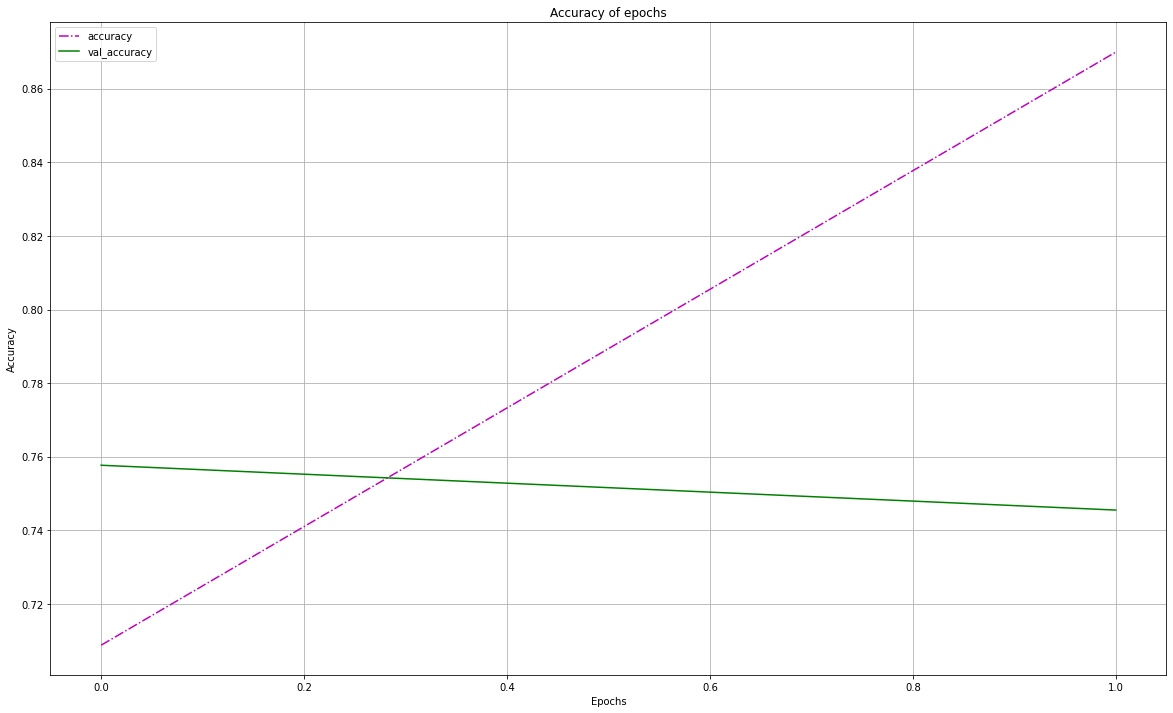

In [28]:
plt.figure(figsize=(20,12))
plt.plot(history.history['accuracy'], '-.', label = f'accuracy', color='m')
plt.plot(history.history['val_accuracy'], '-', label = f'val_accuracy', color='g')
        
plt.legend()
plt.grid('On')
plt.title('Accuracy of epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [29]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 2s 47ms/step - loss: 0.5710 - accuracy: 0.7371


Test score: 0.5710493326187134
Test accuracy: 0.7370718121528625


In [30]:
result['name'].append('GRU')
result['loss'].append(score[0])
result['accuracy'].append(score[1])

### CNN

In [31]:
model = Sequential()
model.add(Embedding(input_dim=word_count, 
                    input_length=training_length, 
                    output_dim=30))

model.add(Conv1D(256, 3, activation='relu'))
model.add(GlobalMaxPool1D())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [32]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=verbose,
                    validation_split=validation_split,
                    callbacks=[early_stopping])


Epoch 1/10
319/319 [==============================] - 57s 177ms/step - loss: 0.5448 - accuracy: 0.5076 - val_loss: 0.4844 - val_accuracy: 0.5049
Epoch 2/10
319/319 [==============================] - 61s 191ms/step - loss: 0.2953 - accuracy: 0.5076 - val_loss: 0.5452 - val_accuracy: 0.5049


In [33]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 1s 19ms/step - loss: 0.6001 - accuracy: 0.5047


Test score: 0.6001314520835876
Test accuracy: 0.5047392249107361


In [34]:
result['name'].append('CNN')
result['loss'].append(score[0])
result['accuracy'].append(score[1])

### Add Dropout

In [35]:
model_5 = Sequential([
    layers.Embedding(input_dim=word_count, 
                     input_length=training_length, output_dim=30),
    layers.Dropout(0.2),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPool1D(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

In [36]:
model_5.compile(optimizer='RMSprop',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [37]:
history_5 = model_5.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=verbose,
                    validation_split=validation_split,
                    callbacks=[early_stopping])

Epoch 1/10
319/319 [==============================] - 34s 103ms/step - loss: 0.5730 - accuracy: 0.6881 - val_loss: 0.5079 - val_accuracy: 0.7450
Epoch 2/10
319/319 [==============================] - 32s 99ms/step - loss: 0.4495 - accuracy: 0.7894 - val_loss: 0.4912 - val_accuracy: 0.7585


In [38]:
score = model_5.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

result['name'].append('Add Dropout')
result['loss'].append(score[0])
result['accuracy'].append(score[1])

45/45 [==============================] - 1s 16ms/step - loss: 0.5286 - accuracy: 0.7356


Test score: 0.528586208820343
Test accuracy: 0.735572874546051


### CNN + RNN

In [39]:
model = Sequential([
    layers.Embedding(input_dim=word_count, 
                     input_length=training_length, output_dim=30),
    layers.Dropout(0.2),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPool1D(),

    layers.RepeatVector(1),
    layers.LSTM(64, recurrent_dropout=0.2),
    
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='RMSprop',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [40]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=verbose,
                    validation_split=validation_split,
                    callbacks=[early_stopping])

Epoch 1/10
319/319 [==============================] - 39s 110ms/step - loss: 0.5808 - accuracy: 0.6814 - val_loss: 0.5163 - val_accuracy: 0.7424
Epoch 2/10
319/319 [==============================] - 33s 103ms/step - loss: 0.4575 - accuracy: 0.7854 - val_loss: 0.4932 - val_accuracy: 0.7538


In [41]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 1s 17ms/step - loss: 0.5208 - accuracy: 0.7327


Test score: 0.5207855701446533
Test accuracy: 0.7326632142066956


In [42]:
result['name'].append('CNN + RNN')
result['loss'].append(score[0])
result['accuracy'].append(score[1])

### GRU + CNN

In [43]:
model = Sequential([
    layers.Embedding(input_dim=word_count, 
                     input_length=training_length, output_dim=30),
    layers.Dropout(0.2),
    layers.Conv1D(128, 5, activation='relu'),
    
    layers.GRU(64, recurrent_dropout=0.2),
    layers.RepeatVector(1),
    layers.GlobalMaxPool1D(),
    
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [44]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=verbose,
                    validation_split=validation_split,
                    callbacks=[early_stopping])

Epoch 1/10
319/319 [==============================] - 115s 353ms/step - loss: 0.5534 - accuracy: 0.7047 - val_loss: 0.4965 - val_accuracy: 0.7522
Epoch 2/10
319/319 [==============================] - 112s 350ms/step - loss: 0.3258 - accuracy: 0.8619 - val_loss: 0.5334 - val_accuracy: 0.7484


In [45]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 3s 58ms/step - loss: 0.5619 - accuracy: 0.7409


Test score: 0.5618600845336914
Test accuracy: 0.7409073114395142


In [46]:
result['name'].append('GRU + CNN optimizer=adam')
result['loss'].append(score[0])
result['accuracy'].append(score[1])

### Result

In [47]:
df_result = pd.DataFrame(result)
df_result

,name,loss,accuracy
0,SimpleRNN,0.589470,0.731473
1,LSTM,0.568034,0.737380
2,GRU,0.571049,0.737072
3,CNN,0.600131,0.504739
4,Add Dropout,0.528586,0.735573
5,CNN + RNN,0.520786,0.732663
6,GRU + CNN optimizer=adam,0.561860,0.740907


Лучший результат показала GRU+CNN optimizer=Adam - 0.740907